In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
df2018 = pd.read_csv('data/nmhss2018.csv')
df2018.columns = map(str.lower, df2018.columns)

In [3]:
sli2018 = df2018.head(1000)
sli2018 = sli2018.filter(regex=("ip.*"))

basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ip2018 = df2018[basic_demog]


In [4]:
colors=['red','green']

In [5]:
# scatter_matrix(ip2018,figsize=[20,20], marker='x',c=ip2018.fundsmha.apply(lambda x:colors[x]), diagonal='kde')
#

In [6]:
# Possible features to look at more:
# FUNDSMHA: Accepts state mental health agency funds as source of payment for mental health treatment services
# FUNDSTATEWELFARE: Accepts state welfare or child and family services agency funds as source of payment for treatment 
# FUNDSTATEJUV: Accepts state corrections/juvenile justice agency funds as source of payment for mental health treatment services (Q.A24)
# FUNDOTHSTATE: Accepts other state government funds as source of payment for mental health treatment services

In [7]:
val_map = {0: 0, 1: 5.5, 2: 15.5, 3: 25.5, 4: 35.5, 5: 45.5, 6: 63, 7: 88, 8: 175.5, 9: 375.5, 10: 750.5, 11: 1250.5,
           12: 1500, -1: None, -2: None}

In [8]:
patient_est = ip2018.replace(val_map)

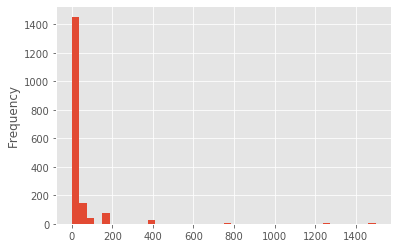

In [9]:
patient_est['ipsextotm'].plot.hist(bins=40)

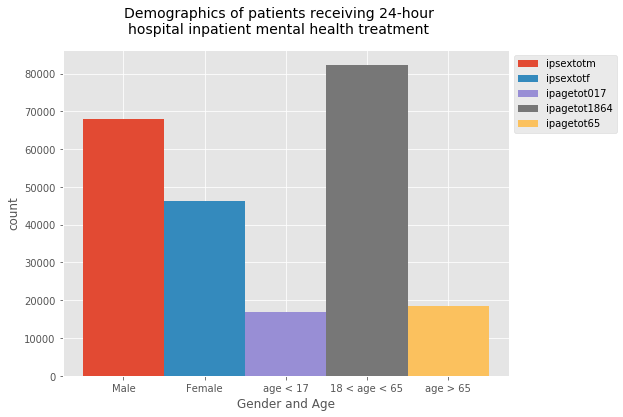

In [10]:
basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ind = np.arange(len(basic_demog))
fig, ax = plt.subplots(figsize=(8, 6))

width = 0.2
for idx, demo in enumerate(basic_demog):
    ax.bar(idx*width, patient_est[patient_est[demo] > 0][demo].sum(), 
           width, label=demo)
    
plt.suptitle('Demographics of patients receiving 24-hour\nhospital inpatient mental health treatment', fontsize=14)
plt.ylabel('count')
plt.xlabel('Gender and Age')
plt.xticks(ind/5, ['Male', 'Female', 'age < 17', '18 < age < 65', 'age > 65'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')


In [11]:
# corr?

In [12]:
# predict funding based on data

standardizer = StandardScaler()

In [29]:
feature = 'percentva'
facilities = df2018[df2018[feature] >= 0].select_dtypes(include=np.number) #only rows with 'known', numeric responses

X_facilities = facilities.drop([feature, 'caseid'], 1).clip(lower=0)
y_facilities = facilities[feature]


standardizer.fit(X_facilities)
X_facilities_standardized = standardizer.transform(X_facilities)

facilities_regression_standardized = LogisticRegression()

facilities_regression_standardized.fit(X_facilities_standardized, y_facilities)

/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
#Select 3 best
best_3_selector = SelectKBest(chi2, k=3)
best_3_selector.fit(X_facilities, y_facilities)
X_facilities_best = best_3_selector.transform(X_facilities)
X_facilities_best.shape

(9158, 3)

In [34]:
X_facilities.columns[best_3_selector.get_support()]

Index(['publicagency', 'opagetot1864', 'opagetot65'], dtype='object')

In [35]:
facilities_predictions = facilities_regression_standardized.predict(X_facilities_standardized)
print(facilities_predictions[:10])

[0 0 1 1 1 0 1 0 0 0]


In [36]:
facilities_probabilities = facilities_regression_standardized.predict_proba(X_facilities_standardized)
print(facilities_probabilities[:10])

[[4.90121250e-01 4.43377695e-01 5.80943105e-02 6.25395280e-03
  4.50527220e-05 1.44605789e-03 2.72912551e-04 3.88768066e-04]
 [6.14092010e-01 2.16608129e-01 7.95749248e-03 1.36748036e-03
  4.84883499e-06 2.82262265e-05 6.58428581e-04 1.59283384e-01]
 [1.92675349e-01 6.89092231e-01 1.13926058e-01 4.45720067e-04
  9.48678993e-06 1.44303053e-04 2.83741191e-03 8.69439929e-04]
 [4.28128123e-01 5.05419744e-01 2.80263284e-02 1.17045423e-03
  3.04848630e-02 6.21982861e-04 1.00682177e-03 5.14168279e-03]
 [2.96173547e-01 5.98520360e-01 1.75072719e-02 6.47126496e-02
  2.25191492e-04 7.53038745e-03 1.26275652e-02 2.70302798e-03]
 [9.78391722e-01 8.18629546e-03 1.59108306e-03 9.76953946e-03
  1.39567340e-03 6.87550560e-05 5.03934251e-04 9.29969707e-05]
 [2.61206847e-01 6.59493016e-01 4.41364973e-02 3.49834797e-02
  1.20880014e-05 1.43906225e-05 1.11276502e-04 4.24046595e-05]
 [9.53252200e-01 4.02343541e-02 5.47211053e-03 6.68142376e-06
  9.12258188e-05 2.98308910e-07 8.91378618e-04 5.17507266e-05]


Text(0, 0.5, 'Probability of percentva')

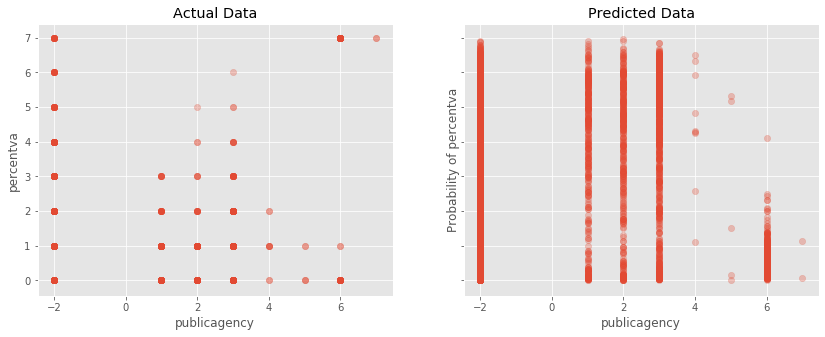

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].scatter(facilities.opagetot1864, facilities[feature], s=40, alpha=0.3)
axs[0].set_title("Actual Data")
axs[0].set_xlabel('opagetot1864')
axs[0].set_ylabel("percentva")

axs[1].scatter(facilities.opagetot1864, 7*facilities_probabilities[:,1], s=40, alpha=0.3)
axs[1].set_title("Predicted Data")
axs[1].set_xlabel('opagetot1864')
axs[1].set_ylabel("Probability of percentva")



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(facilities.focus, facilities.fundsmha, s=40, alpha=0.05)
axs[0].set_title("Actual Data")
axs[0].set_xlabel("Facility focus")
axs[0].set_ylabel("Facility accepts state MHA funds?")

axs[1].scatter(facilities.focus, facilities_probabilities[:,1], s=40, alpha=0.05)
axs[1].set_title("Predicted Data")
axs[1].set_xlabel("Facility focus")
axs[1].set_ylabel("Probability of accepting funds")

